In [1]:
from deepsensor.data.sources import get_era5_reanalysis_data
from deepsensor.data import DataProcessor 
from matplotlib import pyplot as plt
import xarray as xr
from deepsensor.data import TaskLoader
from deepsensor.train import Trainer
from deepsensor.model import ConvNP
import deepsensor.torch
import pandas as pd
import torch.optim as optim
from tqdm import tqdm




/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:44: DeprecationWa

In [2]:
# Using the same settings allows use to use pre-downloaded cached data 
data_range=("2010-06-25", "2010-06-30") 
bounding_box_antarctica=(-180, 180, -90, -60) 
extent=bounding_box_antarctica
era5_var_IDs=["2m_temperature"] 
cache_dir=".datacache"
era5_raw_ds=get_era5_reanalysis_data(era5_var_IDs, extent =bounding_box_antarctica, date_range=data_range, cache=False, cache_dir=cache_dir)


/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=27199) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


In [3]:
cmip_raw_ds = xr.open_dataset("/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/cmip6_raw_ds.nc")



In [4]:
data_processor=DataProcessor(x1_name="lat", x2_name="lon")
era5_ds, cmip_ds =data_processor([era5_raw_ds, cmip_raw_ds])


In [5]:
task_loader = TaskLoader(
    context=[era5_ds, cmip_ds]*2,
    target=[era5_ds],
    context_delta_t=[-1, -1, 0, 0],
    target_delta_t=1,
)


In [6]:
model = ConvNP(data_processor, task_loader)
opt = optim.Adam(model.model.parameters(), lr=5e-5)


dim_yc inferred from TaskLoader: (1, 1, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1439
encoder_scales inferred from TaskLoader: [0.00034746347228065133, 0.002605976304039359, 0.00034746347228065133, 0.002605976304039359]
decoder_scale inferred from TaskLoader: 0.0006949270326615705


In [7]:
train_tasks = []
for date in pd.date_range("2010-06-26", "2010-06-28"):
    task = task_loader(date, context_sampling="all", target_sampling = "all")
    train_tasks.append(task)

In [8]:
# Train model
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm(range(2)):
    batch_losses = trainer(train_tasks)

100%|██████████| 2/2 [00:23<00:00, 11.92s/it]


In [9]:
date = "2010-06-29"
test_task = task_loader(date, context_sampling=["all", "all", "all", "all"], target_sampling="all")
predictions = model.predict(test_task, X_t= era5_raw_ds)

/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/deepsensor/model/model.py:388: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X_t = X_t.isel(time=0).drop("time")


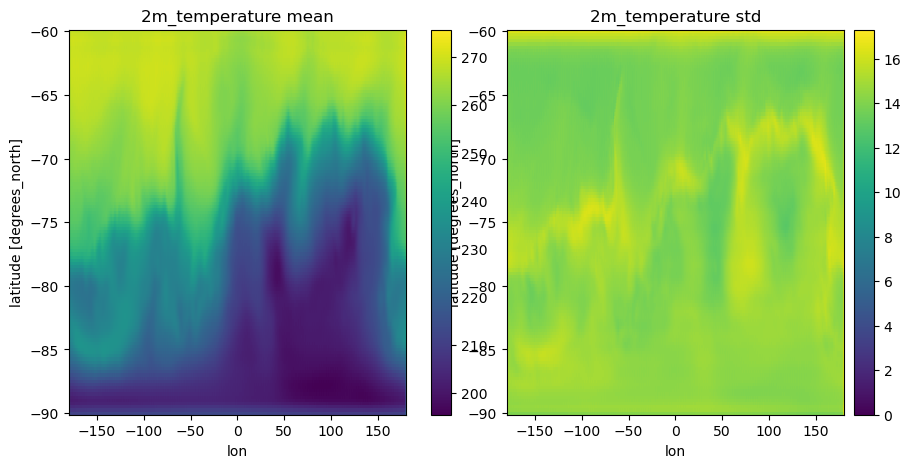

In [10]:

fig = deepsensor.plot.prediction(predictions, date)